<a href="https://colab.research.google.com/github/PROFOUNDIVE/AIDHellCamp2/blob/dev1/baseline_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 6공학관 층 분류하기 - AID 지옥캠프2

- 작성된 환경: Window 11, Pip, Python 3.9, CUDA 11.8, VScode
- Google Colab 등의 클라우드 컴퓨팅 환경에서는 다른 동작을 할 가능성 있음

## 실행 전 사전 준비

### 모듈
- shell에서
``` shell
# Colab 환경은 필요한 모든 모듈이 설치되어 있어 설치할 필요 x
```
``` shell
# 본인 GPU(CUDA)에 맞는 버전을 설치해주세요
# 참고: https://pytorch.org/get-started/locally/
# ex1) Pip, CPU 환경
# pip3 install torch torchvision torchaudio
# ex2) Conda, CUDA 12.4 환경
# conda install pytorch torchvision torchaudio pytorch-cuda=12.4 -c pytorch -c nvidia
pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
```
```shell
pip3 install -U scikit-learn
pip3 install -U matplotlib
pip3 install tqdm
```

### 데이터 파일
- 데이터 파일을 root 경로(baseline_code.ipynb가 있는 폴더)에 압축해제 해주세요
- data link: https://www.kaggle.com/datasets/hyunseok21/jiokdata
- colab 환경이라면 다음 [챕터](#colab-환경에서-kaggle파일-다운로드하기---로컬환경이라면-건너뛰기) 확인해주세요
``` shell
📁root
 ├─📁test
 ├─📁train
 │  ├─📁2F_train
 │  ├─📁3F_train
 │  ├─📁4F_train
 │  └─📁5F_train
 └─📜baseline_code.ipynb
```

#### Colab 환경에서 kaggle파일 다운로드하기 - **로컬환경이라면 건너뛰기**

In [2]:
# 실행 시 업로드 버튼 활성화
# kaggle에서 발급받은 api key가 담긴 json 파일 업로드
COLAB = True
try:
  from google.colab import files
  files.upload()
except:
  COLAB = False

Saving kaggle.json to kaggle.json


In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
if COLAB:
  import kagglehub
  import shutil

  # Download latest version
  path = kagglehub.dataset_download("hyunseok21/jiokdata")

  print("Path to dataset files:", path)
  shutil.move(path+'/jiokdata/train', '/content/')
  shutil.move(path+'/jiokdata/test', '/content/')

100%|██████████| 5.72G/5.72G [00:41<00:00, 150MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/hyunseok21/jiokdata/versions/1


# Train Data로 학습하기

## 모델 학습 (with train data)

### 모듈 불러오기

In [ ]:
import time
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm

### CUDA 코어 테스트 & 할당

In [ ]:
if torch.cuda.is_available():
  print(torch.cuda.get_device_name())
  print(torch.__version__)
  print(torch.version.cuda)
  x = torch.randn(1).cuda()
  print(x)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### 하이퍼 파라미터 (Hyper Parameter)

In [ ]:
params = {
  # For Train
  'epoch': 2,
  'batch_size': 16,

  # CPU worker
  'workers': 4, # 본인 cpu 쓰레드의 절반 정도

  # imgShow
  'num_show_img': 5, # 데이터가 잘 로드 되었는지 확인 하는 셀에서 보여줄 데이터 개수, 학습과 관련 없음

  # For Optimizer
  'learning_rate': 0.001,
}

### 저장할 학습 완료 모델 파일 이름

In [ ]:
pt_file_name = 'model.pt'

### 데이터 라벨링

In [ ]:
class_names = {
  "0": "2F",
  "1": "3F",
  "2": "4F",
  "3": "5F",
}

### 데이터 전처리 & 데이터 로더 정의 & 사이즈 확인


In [1]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

# 1. 데이터 전처리(transform) 정의
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomChoice([
        transforms.Lambda(lambda x: x),
        transforms.RandomResizedCrop((224, 224), scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(p=1.0),
        transforms.RandomRotation(degrees=30),
        transforms.ColorJitter(brightness=0.2, contrast=0.2,
                               saturation=0.2, hue=0.1)
    ]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 2. 데이터셋 로드 (train_transforms 사용)
dataset = datasets.ImageFolder(root='./train', transform=train_transforms)

# 3. 데이터셋 분할 (train, valid, test)
train_idx, tmp_idx = train_test_split(
    list(range(len(dataset))), test_size=0.2, random_state=42
)
data_sets = {
    'train': Subset(dataset, train_idx)
}

val_idx, test_idx = train_test_split(
    tmp_idx, test_size=0.5, random_state=42
)
data_sets['valid'] = Subset(dataset, val_idx)
data_sets['test'] = Subset(dataset, test_idx)

# 4. DataLoader 정의 (params에서 설정 가져오기)
dataloaders = {
    'train': DataLoader(data_sets['train'],
                        batch_size=params['batch_size'],
                        shuffle=True,
                        num_workers=params['workers'],
                        pin_memory=True),
    'valid': DataLoader(data_sets['valid'],
                        batch_size=params['batch_size'],
                        shuffle=False,
                        num_workers=params['workers'],
                        pin_memory=True),
    'test': DataLoader(data_sets['test'],
                       batch_size=params['batch_size'],
                       shuffle=False,
                       num_workers=params['workers'],
                       pin_memory=True)
}

# 5. 배치 수 계산 및 출력
batch_num = {
    'train': len(dataloaders['train']),
    'valid': len(dataloaders['valid']),
    'test': len(dataloaders['test'])
}

print('batch_size: %d, train/valid/test: %d / %d / %d'
      % (params['batch_size'],
         batch_num['train'],
         batch_num['valid'],
         batch_num['test']))


FileNotFoundError: [Errno 2] No such file or directory: './train'

## EfficientNet pre-trained model 불러오기

In [ ]:
!pip install validators matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 1.6 MB/s eta 0:00:00


In [ ]:
import torch
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cpu for inference


In [ ]:
efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils')

efficientnet.eval().to(device)

Downloading: "https://github.com/NVIDIA/DeepLearningExamples/zipball/torchhub" to /root/.cache/torch/hub/torchhub.zip
Downloading: "https://api.ngc.nvidia.com/v2/models/nvidia/efficientnet_b0_pyt_amp/versions/20.12.0/files/nvidia_efficientnet-b0_210412.pth" to /root/.cache/torch/hub/checkpoints/nvidia_efficientnet-b0_210412.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 104MB/s]
Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


EfficientNet(
  (stem): Sequential(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (activation): SiLU(inplace=True)
  )
  (layers): Sequential(
    (0): Sequential(
      (block0): MBConvBlock(
        (depsep): Sequential(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (se): SequentialSqueezeAndExcitation(
          (squeeze): Linear(in_features=32, out_features=8, bias=True)
          (expand): Linear(in_features=8, out_features=32, bias=True)
          (activation): SiLU(inplace=True)
          (sigmoid): Sigmoid()
          (mul_a_quantizer): Identity()
          (mul_b_quantizer): Identity()
        )
      

## Example of inference

In [ ]:
uris = [
    'http://images.cocodataset.org/test-stuff2017/000000024309.jpg',
    'http://images.cocodataset.org/test-stuff2017/000000028117.jpg',
    'http://images.cocodataset.org/test-stuff2017/000000006149.jpg',
    'http://images.cocodataset.org/test-stuff2017/000000004954.jpg',
]

batch = torch.cat(
    [utils.prepare_input_from_uri(uri) for uri in uris]
).to(device)

In [ ]:
with torch.no_grad():
    output = torch.nn.functional.softmax(efficientnet(batch), dim=1)

results = utils.pick_n_best(predictions=output, n=5)

sample 0: [('laptop, laptop computer', '49.9%'), ('notebook, notebook computer', '36.2%'), ('desk', '3.7%'), ('mouse, computer mouse', '0.5%'), ('space bar', '0.5%')]
sample 1: [('mashed potato', '87.0%'), ('meat loaf, meatloaf', '5.2%'), ('broccoli', '1.9%'), ('plate', '0.3%'), ('guacamole', '0.1%')]
sample 2: [('racket, racquet', '55.8%'), ('tennis ball', '8.4%'), ('ping-pong ball', '2.6%'), ('golf ball', '0.6%'), ('baseball', '0.6%')]
sample 3: [('kelpie', '52.7%'), ('malinois', '4.1%'), ('groenendael', '3.0%'), ('schipperke', '3.0%'), ('Scottish deerhound, deerhound', '2.6%')]


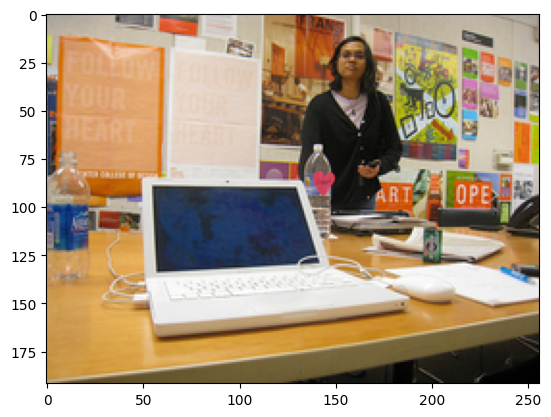

[('laptop, laptop computer', '49.9%'), ('notebook, notebook computer', '36.2%'), ('desk', '3.7%'), ('mouse, computer mouse', '0.5%'), ('space bar', '0.5%')]


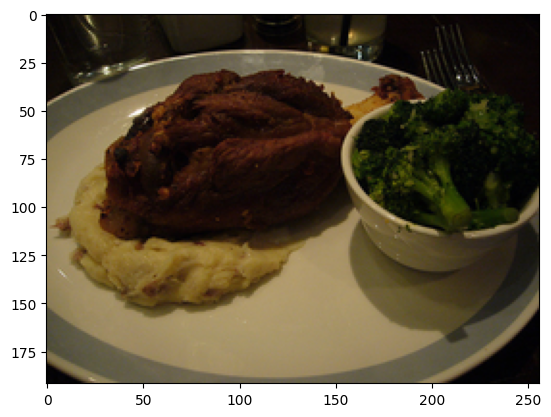

[('mashed potato', '87.0%'), ('meat loaf, meatloaf', '5.2%'), ('broccoli', '1.9%'), ('plate', '0.3%'), ('guacamole', '0.1%')]


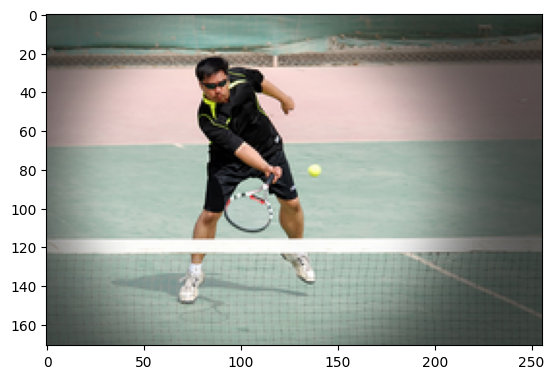

[('racket, racquet', '55.8%'), ('tennis ball', '8.4%'), ('ping-pong ball', '2.6%'), ('golf ball', '0.6%'), ('baseball', '0.6%')]


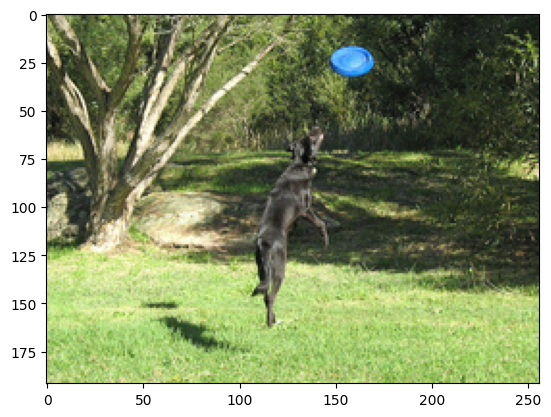

[('kelpie', '52.7%'), ('malinois', '4.1%'), ('groenendael', '3.0%'), ('schipperke', '3.0%'), ('Scottish deerhound, deerhound', '2.6%')]


In [ ]:
for uri, result in zip(uris, results):
    img = Image.open(requests.get(uri, stream=True).raw)
    img.thumbnail((256,256), Image.Resampling.LANCZOS)
    plt.imshow(img)
    plt.show()
    print(result)

In [ ]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=f4a87defa8137192064f9eb64bf9b08f7f4f431f949338ae6e1fda921d98cb74
  Stored in directory: /root/.cache/pip/wheels/8b/6f/9b/231a832f811ab6ebb1b32455b177ffc6b8b1cd8de19de70c09
Successfully built efficientnet_pytorch


## EfficientNet demo

### requirements

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import numpy as np

## Train

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from efficientnet_pytorch import EfficientNet
from tqdm import tqdm  # For progress bar

# Custom Dataset class (you need to implement it or use an existing dataset)
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Preprocessing pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to match EfficientNet input size
    transforms.ToTensor(),  # Convert image to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize based on ImageNet
])

# Assuming you have lists of image paths and corresponding labels
train_image_paths = [...]  # List of paths to training images
train_labels = [...]  # List of labels for training images

# Create DataLoader for the training dataset
train_dataset = CustomDataset(train_image_paths, train_labels, transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Load pre-trained EfficientNet B0 model
model = EfficientNet.from_pretrained('efficientnet-b0')

# Modify the output layer to output 4 classes
model._fc = nn.Linear(model._fc.in_features, 4)

# Define the loss function (CrossEntropyLoss automatically applies softmax)
criterion = nn.CrossEntropyLoss()

# Define the optimizer (e.g., Adam)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Move model to device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    # Iterate over the training data
    for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Print epoch stats
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

# Save the fine-tuned model
torch.save(model.state_dict(), 'path_to_finetuned_model.pth')
print("Model saved to 'path_to_finetuned_model.pth'")

Loaded pretrained weights for efficientnet-b0


Epoch 1/10:   0%|          | 0/1 [00:00<?, ?it/s]


AttributeError: 'ellipsis' object has no attribute 'read'

### Train 함수

In [ ]:
def train_model(model, criterion, optimizer, dataloaders: dict, num_epochs=25):
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  train_loss, train_acc, valid_loss, valid_acc = [], [], [], []

  for epoch in range(num_epochs):
    print()
    print('Epoch {}/{}'.format(epoch+1, num_epochs), end=": ")
    print('-'*10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'valid']:
      if phase =='train':
        model.train() # Set model to training mode
      else:
        model.eval() # Set model to evaluate mode

      running_loss, running_corrects, num_cnt = 0.0, 0, 0

      count = 1
      #Iterate over data.
      pbar_dataloaders = tqdm(dataloaders[phase],
                              desc=phase,
                              ncols=70)
      for inputs, labels in pbar_dataloaders:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)

          # backward only if in training phase
          if phase == 'train':
            loss.backward()
            optimizer.step()

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        num_cnt += len(labels)
        count += 1
      pbar_dataloaders.close()

      epoch_loss = float(running_loss / num_cnt)
      epoch_acc = float((running_corrects.double() / num_cnt).cpu()*100)

      if phase == 'train':
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)
      else:
        valid_loss.append(epoch_loss)
        valid_acc.append(epoch_acc)
      print()
      print(f'{phase} Loss: {epoch_loss:.2f} Acc: {epoch_acc:.1f}')

      # deep copy the model
      if phase == 'valid' and epoch_acc > best_acc:
        best_idx = epoch + 1
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        print('==> best model saved - %d / %.1f'%(best_idx, best_acc))

  time_elapsed = time.time() - since
  print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
  print('Best valid Acc: idx=%d , %.1f'%(best_idx, best_acc))

  # load best model weights
  model.load_state_dict(best_model_wts)
  torch.save(model.state_dict(), pt_file_name)
  print('model saved')
  return model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc

### 모델 구성

In [ ]:
class BaseModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=4, kernel_size=1, stride=1, padding=0)

        self.fc1 = nn.Linear(4 * 224 * 224, 8)
        self.fc2 = nn.Linear(8, 4)

    def forward(self, x):
        # Weak activation with minimal learning capacity
        x = F.sigmoid(self.conv1(x))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return x


### 데이터 확인

In [ ]:
def imgShow(input, title=None):
  """Img show for Tensor."""
  input = input.numpy().transpose((1,2,0))
  input = np.clip(input, 0, 1)
  plt.imshow(input)
  if title is not None:
    plt.title(title)
  plt.pause(0.001) # pause a bit so that plots are updated

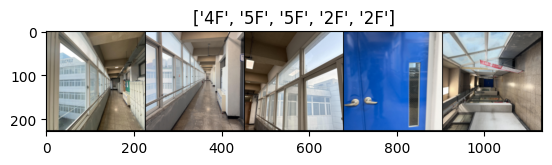

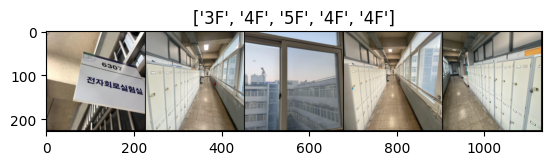

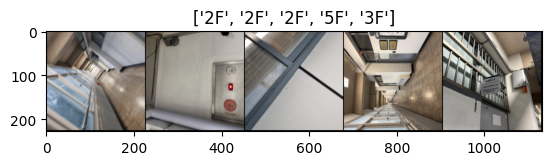

In [ ]:
# train data
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs[:params['num_show_img']])
imgShow(out, title=[class_names[str(int(x))] for x in classes[:params['num_show_img']]])
# valid data
inputs, classes = next(iter(dataloaders['valid']))
out = torchvision.utils.make_grid(inputs[:params['num_show_img']])
imgShow(out, title=[class_names[str(int(x))] for x in classes[:params['num_show_img']]])
# test data
inputs, classes = next(iter(dataloaders['test']))
out = torchvision.utils.make_grid(inputs[:params['num_show_img']])
imgShow(out, title=[class_names[str(int(x))] for x in classes[:params['num_show_img']]])

### 모델을 장치로 할당

In [ ]:
model = BaseModel()

# setting
model = model.to(device)

# CUDA 확인
if next(model.parameters()).is_cuda:
  print("Model to CUDA")
else:
  print("Model to CPU")

Model to CUDA


### 손실함수 & 옵티마이저

In [ ]:
# 손실함수
criterion = torch.nn.CrossEntropyLoss()

# 옵티마이저
optimizer = torch.optim.SGD(model.parameters(),
                            lr=params['learning_rate'],
                          )

### 학습 시작

In [ ]:
model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc = train_model(model, criterion, optimizer, dataloaders, num_epochs=params['epoch'])


Epoch 1/2: ----------


train: 100%|████████████████████████| 361/361 [04:08<00:00,  1.45it/s]



train Loss: 1.39 Acc: 24.5


valid: 100%|██████████████████████████| 46/46 [00:47<00:00,  1.04s/it]



valid Loss: 1.39 Acc: 25.0
==> best model saved - 1 / 25.0

Epoch 2/2: ----------


train: 100%|████████████████████████| 361/361 [04:13<00:00,  1.42it/s]



train Loss: 1.39 Acc: 25.5


valid: 100%|██████████████████████████| 46/46 [00:54<00:00,  1.18s/it]


valid Loss: 1.39 Acc: 28.2
==> best model saved - 2 / 28.2
Training complete in 10m 5s
Best valid Acc: idx=2 , 28.2
model saved


## 학습 결과 분석

best model info:
Model extracted from epoch 2
Valid Acc=28 / Valid Loss=1.4


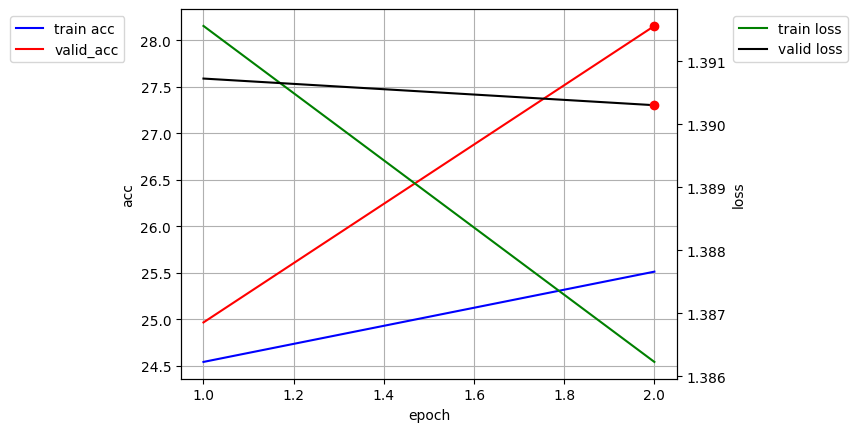

In [ ]:
## 결과 그래프 그리기
print('best model info:\nModel extracted from epoch %d\nValid Acc=%1.f / Valid Loss=%.1f'%(best_idx, valid_acc[best_idx-1], valid_loss[best_idx-1]))
fig, ax1 = plt.subplots()

ax1.plot([n for n in range(1,len(train_acc)+1)], train_acc, 'b-', label='train acc')
ax1.plot([n for n in range(1,len(valid_acc)+1)], valid_acc, 'r-', label ='valid_acc')
plt.plot(best_idx, valid_acc[best_idx-1], 'ro')
ax1.set_xlabel('epoch')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('acc', color='k')
ax1.tick_params('y', colors='k')
plt.legend(bbox_to_anchor=(-0.1, 1.0), loc="upper right")
plt.grid()

ax2 = ax1.twinx()
ax2.plot([n for n in range(1,len(train_loss)+1)], train_loss, 'g-', label='train loss')
ax2.plot([n for n in range(1,len(valid_loss)+1)], valid_loss, 'k-', label='valid loss')
plt.plot(best_idx, valid_loss[best_idx-1], 'ro')
ax2.set_ylabel('loss', color='k')
ax2.tick_params('y', colors='k')
plt.legend(bbox_to_anchor=(1.1, 1.0), loc="upper left")


plt.show()

## 모델 TEST

In [ ]:
def test_and_visualize_model(model, dataloaders, phase = 'test', num_images=4):
  # phase = 'train', 'valid', 'test'

  was_training = model.training
  model.eval()

  running_loss, running_corrects, num_cnt = 0.0, 0, 0

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders[phase]):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      loss = criterion(outputs, labels) # batch의 평균 loss 출력

      running_loss += loss.item() * inputs.size(0)
      running_corrects += torch.sum(preds == labels.data)
      num_cnt += inputs.size(0) # batch size

    test_loss = running_loss / num_cnt
    test_acc = running_corrects.double() / num_cnt
    print('test done : loss/acc : %.2f / %.1f' % (test_loss, test_acc*100))

  # 예시 그림 출력
  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders[phase]):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(1, num_images+1):
        ax = plt.subplot(num_images//2, 2, j)
        ax.axis('off')
        ax.set_title('%s : %s -> %s' %(
          'True' if class_names[str(labels[j].cpu().numpy())] == class_names[str(preds[j].cpu().numpy())] else 'False',
          class_names[str(labels[j].cpu().numpy())],
          class_names[str(preds[j].cpu().numpy())]
        ))
        imgShow(inputs.cpu().data[j])

      if i == 0: break

  model.train(mode=was_training) # 다시 train모드로 전환

test done : loss/acc : 1.40 / 26.2


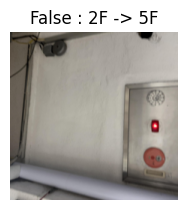

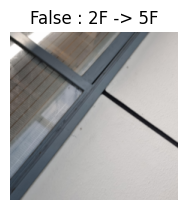

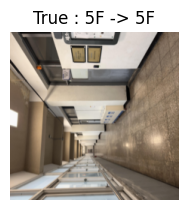

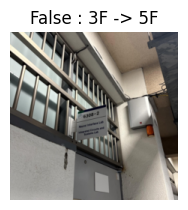

In [ ]:
test_and_visualize_model(model, dataloaders, phase='test')

# Test 데이터 분류 및 CSV 만들기

In [ ]:
import glob
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import sys

In [ ]:
data_path = './test'
image_files = sorted(glob.glob(data_path + '/*'))
csv_filename = 'answer.csv'

os_name = sys.platform
path_split = '/'
if os_name.startswith('win'):
  path_split = '\\'

In [ ]:
class TestImageDataset(Dataset):
  def __init__(self, files, transform):
    super().__init__()
    self.files = files
    self.transform = transform

  def __len__(self):
    return len(self.files)

  def __getitem__(self, index):
    file = self.files[index]
    try:
        img = Image.open(file).convert('RGB')
    except Exception as e:
        print(f"Error opening image {file}: {e}")
        raise
    img = self.transform(img)

    return img, file.split(path_split)[-1]

In [ ]:
test_transform = transforms.Compose([
                        transforms.Resize((224, 224)), # 224x224 사이즈로 변환
                        transforms.ToTensor(), # 텐서화
                      ])

In [ ]:
test_dataset = TestImageDataset(image_files, test_transform)

In [ ]:
test_loader = DataLoader(test_dataset,
                         batch_size=params['batch_size'],
                         shuffle=False,
                         )

In [ ]:
model_dict = torch.load(pt_file_name, map_location=device)
trained_model = BaseModel()
trained_model.load_state_dict(model_dict)
trained_model = trained_model.to(device)

# CUDA 확인
print(f"CUDA:{next(trained_model.parameters()).is_cuda}")

In [ ]:
def test_and_make_csv(model, dataloader):
  # phase = 'train', 'valid', 'test'

  model.eval()

  answer_csv = 'id,floor\n'

  pbar_dataloaders = tqdm(dataloader,
                          desc='Making Csv',
                          ncols=70)
  with torch.no_grad():
    for inputs, filenames in pbar_dataloaders:
      inputs = inputs.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(len(preds)):
        answer_csv += f'{filenames[j].split(".")[0]},{class_names[str(preds[j].cpu().numpy())]}\n'
  pbar_dataloaders.close()

  with open(csv_filename, 'w') as file:
    file.write(answer_csv)
    print(f'{csv_filename}가 생성되었습니다.')

In [ ]:
test_and_make_csv(trained_model, test_loader)

Making Csv: 100%|█████████████████████| 50/50 [01:15<00:00,  1.52s/it]

answer.csv가 생성되었습니다.
